In [1]:
import os 
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
data = "datas\\names.txt" 
data_path = os.path.join(os.getcwd(),data)

In [3]:
text_data = open(data_path,"r").read().splitlines()
type(text_data)

list

In [4]:
chars   = sorted(list(set("".join(text_data))))
stoi    = {s:i+1 for i,s in enumerate(chars)} 
stoi["."] = 0
itos    = {s:i for i,s in sorted((stoi.items()))}

## Build Dataset

In [5]:
def build_dataset(dataset:list=None,block_size:int=3):

    X,Y = [],[]
    for word in dataset:

        context = [0] * block_size
        for char in word +".":
            idx = stoi[char]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx] # crop and append
    
    X = torch.tensor(X,device="cuda")
    Y = torch.tensor(Y,device="cuda") 
    print(X.shape,Y.shape)
    return X,Y


random.seed(42)
random.shuffle(text_data,random=random.seed(42))
n1 = int(0.8 * len(text_data))
n2 = int(0.9 * len(text_data))

x_train,y_train = build_dataset(text_data[:n1])
x_val,y_val     = build_dataset(text_data[n1:n2])
x_test,y_test   = build_dataset(text_data[n2:]) 


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Modules

In [6]:
class Linear:

    def __init__(self,fan_in,fan_out,bias=True) :
        self.weight = torch.randn((fan_in,fan_out),generator=g,device="cuda:0") / fan_in ** 0.5
        self.bias   = torch.zeros(fan_out,device="cuda:0") if bias else None
        
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [95]:
class BatchNormalization:

    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps            = eps 
        self.momentum       = momentum
        self.training       = True
        # parameter
        self.gamma          = torch.ones(dim,device="cuda:0")
        self.beta           = torch.zeros(dim,device="cuda:0")
        # buffer parameter 
        self.runnnig_mean   = torch.zeros(dim,device="cuda:0")
        self.runnnig_std    = torch.ones(dim,device="cuda:0")
    def __call__(self, x):
        if self.training:
            x_mean          = torch.mean(x,dim=0,keepdim=True)
            x_var           = torch.var(x,dim=0,keepdim=True,unbiased=True)
        else:
            x_mean          = self.runnnig_mean
            x_var           = self.runnnig_var

        x_hat               = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out            = self.gamma * x_hat + self.beta
        # update the buffer         
        if self.training:
            with torch.no_grad():
                self.runnnig_mean   = (1 - self.momentum) * self.runnnig_mean + self.momentum * x_mean
                self.runnnig_std    = (1 - self.momentum) * self.runnnig_std + self.momentum * x_var
        return self.out
    def parameters(self):
        return [self.gamma,self.beta]

In [96]:
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [9]:
n_emb       = 10
n_hidden    = 100
block_size  = 3
vocab_size  = len(itos)

g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
C           = torch.randn((vocab_size,n_emb),                          generator=g,device="cuda:0")

In [10]:
layers = [
    Linear(fan_in=n_emb * block_size,fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=vocab_size)
]


with torch.no_grad():
    layers[-1].weight *= 0.1           # for fixing initial loss
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 1         

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total numbers of parameters in this model : {sum(p.nelement() for p in parameters)}")
for para in parameters:
    para.requires_grad = True

Total numbers of parameters in this model : 46497


In [11]:
n_iter      = 200000
batch_size  = 32
loss_i      = []

for i in range(1):

    # mini batch
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 
    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    x           = emb.view(emb.shape[0],-1) # (32,30)
    for layer in layers:
        x = layer(x)                        # output ==>> (32 * 27) ==>> (batch_size * vocab_size)
    loss = F.cross_entropy(x,y_batch)       # expect initial loss   ==>> (1/27) = 
    #backward pass 
    for layer in layers:
        layer.out.retain_grad() 

    for para in parameters:
        para.grad = None
    loss.backward()
    # update the parameters
    lr = 0.1 if n_iter < 100000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += - lr * para.grad

    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())
    

      0/ 200000 :   3.3035


 layer 1 (      Tanh):     mean +0.06,     std 0.61,   var 0.37,   saturated 3.09%
 layer 3 (      Tanh):     mean -0.01,     std 0.48,   var 0.23,   saturated 0.22%
 layer 5 (      Tanh):     mean -0.00,     std 0.42,   var 0.17,   saturated 0.00%
 layer 7 (      Tanh):     mean +0.01,     std 0.37,   var 0.14,   saturated 0.00%
 layer 9 (      Tanh):     mean -0.01,     std 0.33,   var 0.11,   saturated 0.00%


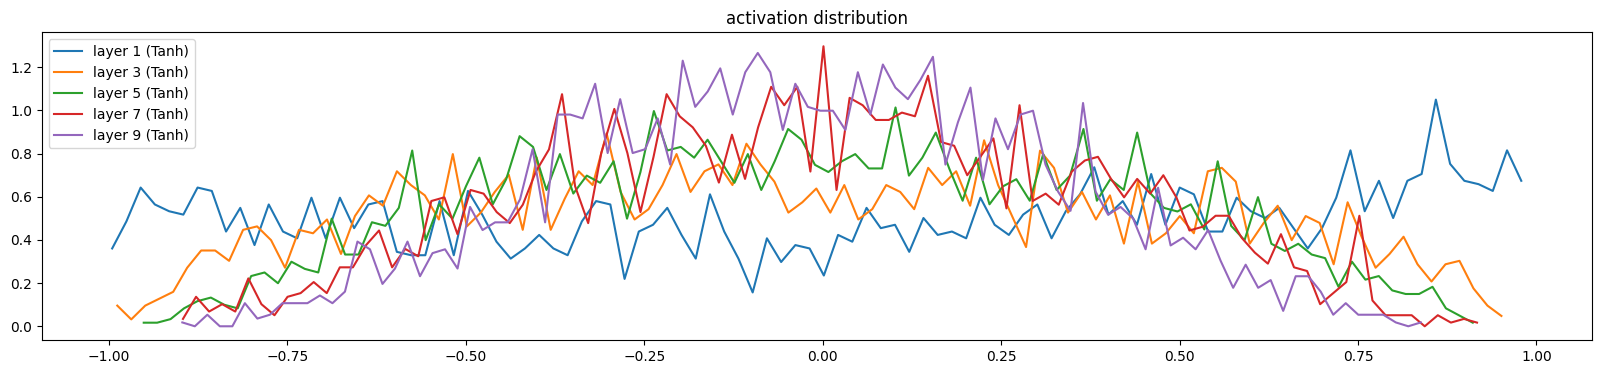

In [12]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out
        t = t.cpu().detach()
        print(" layer %d (%10s):     mean %+.2f,     std %.2f,   var %.2f,   saturated %.2f%%" % (i,layer.__class__.__name__,t.mean().item(),t.std().item(),t.var().item(),((t.abs())>0.97).float().mean().item() * 100))
        hy,hx = torch.histogram(t,density=True)     # hist, bin_edges 
        plt.plot(hx[:-1].detach(),hy.detach())      
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution");

## Understanding the Tanh Function

- The Tanh function is often used in neural networks because it produces outputs between -1 and 1, making it useful for centering data around zero. 
- Tanh squeeze the input values, particularly when they are large, leading to a `reduced output variance.` 
- This reduction in variance can affect how gradients propagate through the network, potentially leading to issues like the vanishing gradient problem.

- The Role of the 5/3 Gain

    1. Variance Reduction by Tanh:
        - ![alt text](<Screenshot 2024-08-24 164637.png>)
        
            The result of this integral, approximately 0.39, represents the average value of tanh^⁡2(x). This means that the variance of the output is approximately 0.39 times the variance of the input.

    2. Compensating for Variance Reduction:
        - To counteract the reduction in variance caused by the Tanh function, we apply a gain factor to the weights before the Tanh activation. The goal is to maintain the variance of the output at 1, which is important for maintaining a stable training process.
        
           - `Standard Deviation = sqrt(Variance)`
           - sqrt(0.39) = 5/3


            ```
            with torch.no_grad():
                layers[-1].weight *= 0.1           # for fixing initial loss
                for layer in layers[:-1]:
                    if isinstance(layer,Linear):
                        layer.weight *= 5/3

​

- layer 1 (      Tanh):     mean +0.00,     std 0.63,   var 0.39,   saturated 3.28%
- layer 3 (      Tanh):     mean +0.00,     std 0.49,   var 0.24,   saturated 0.03%
- layer 5 (      Tanh):     mean -0.01,     std 0.39,   var 0.15,   saturated 0.00%
- layer 7 (      Tanh):     mean +0.01,     std 0.35,   var 0.12,   saturated 0.00%
- layer 9 (      Tanh):     mean -0.01,     std 0.32,   var 0.10,   saturated 0.00%


#### A significant drop in variance is observed between layers, with a decrease of approximately 39% from layer to layer. 

## Parameter initialization

- we put last layer weight as 0.1, for fixing the initial loss (squeeze the loss into accountable manner). 
- `gain = 5/3`. 


In [19]:
layers = [
    Linear(fan_in=n_emb * block_size,fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=vocab_size)
]


with torch.no_grad():
    layers[-1].weight *= 0.1           # for fixing initial loss
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3         # he initialization 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total numbers of parameters in this model : {sum(p.nelement() for p in parameters)}")
for para in parameters:
    para.requires_grad = True

Total numbers of parameters in this model : 46497


In [14]:
n_iter      = 200000
batch_size  = 32
loss_i      = []

for i in range(1):

    # mini batch
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 
    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    x           = emb.view(emb.shape[0],-1) # (32,30)
    for layer in layers:
        x = layer(x)                        # output ==>> (32 * 27) ==>> (batch_size * vocab_size)
    loss = F.cross_entropy(x,y_batch)       # expect initial loss   ==>> (1/27) = 
    #backward pass 
    for layer in layers:
        layer.out.retain_grad()
        
    for para in parameters:
        para.grad = None
    loss.backward()
    # update the parameters
    lr = 0.1 if n_iter < 100000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += - lr * para.grad

    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())
    

      0/ 200000 :   3.2918


 layer 1 (      Tanh):     mean -0.04,     std 0.75,   var 0.56,   saturated 19.06%
 layer 3 (      Tanh):     mean -0.01,     std 0.70,   var 0.48,   saturated 9.78%
 layer 5 (      Tanh):     mean -0.03,     std 0.67,   var 0.45,   saturated 6.94%
 layer 7 (      Tanh):     mean +0.02,     std 0.67,   var 0.45,   saturated 7.94%
 layer 9 (      Tanh):     mean -0.00,     std 0.66,   var 0.43,   saturated 6.31%


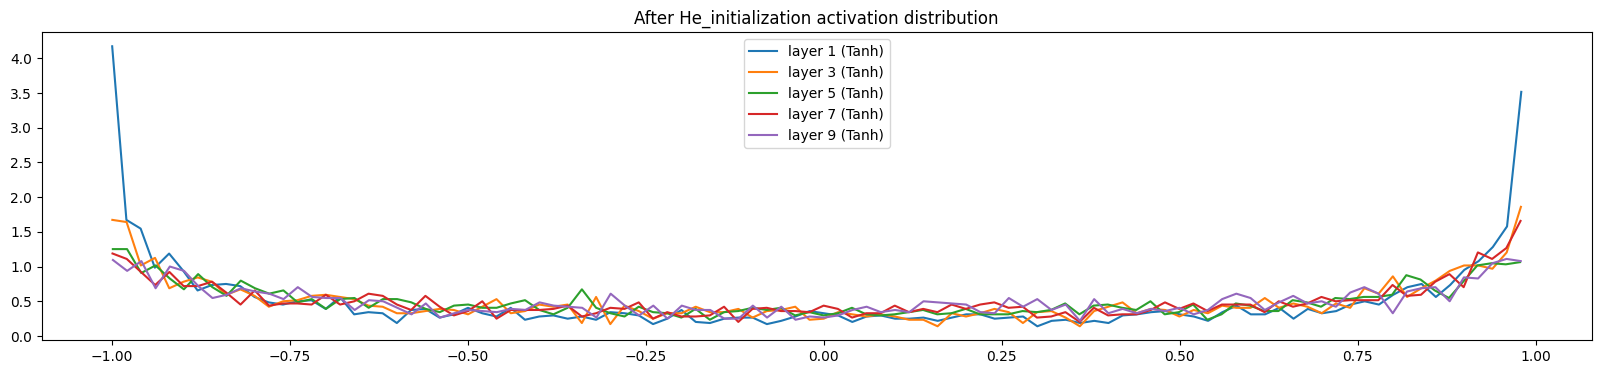

In [15]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out
        t = t.cpu().detach()
        print(" layer %d (%10s):     mean %+.2f,     std %.2f,   var %.2f,   saturated %.2f%%" % (i,layer.__class__.__name__,t.mean().item(),t.std().item(),t.var().item(),((t.abs())>0.97).float().mean().item() * 100))
        #print("layer %d (%10s):     mean %+.2f,     std %.2f,   saturated %.2f%%" % (i,layer.__class__.__name__,t.mean().item(),t.std().item(),((t.abs())>0.97).float().mean().item() * 100))
        hy,hx = torch.histogram(t,density=True)     # hist, bin_edges 
        plt.plot(hx[:-1].detach(),hy.detach())      
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("After He_initialization activation distribution");

- When You have Sandwich of linear layer alone, Initialization parameter by `(fan_in)**0.5`, would have conserve the `std = 1`,
- But we have interspreaded `Linear layer` with `Tanh()` layer (squashing function) squashing the distribution, so that we need `gain` for keep expanding to fight against the squashing. 
- `Gain = 5/3` is better value for fighting gainst this function.   

## Gradient 

 layer 1 (      Tanh):     mean +0.00,     std 0.00,   var 0.00,   saturated 0.00%
 layer 3 (      Tanh):     mean +0.00,     std 0.00,   var 0.00,   saturated 0.00%
 layer 5 (      Tanh):     mean +0.00,     std 0.00,   var 0.00,   saturated 0.00%
 layer 7 (      Tanh):     mean -0.00,     std 0.00,   var 0.00,   saturated 0.00%
 layer 9 (      Tanh):     mean +0.00,     std 0.00,   var 0.00,   saturated 0.00%


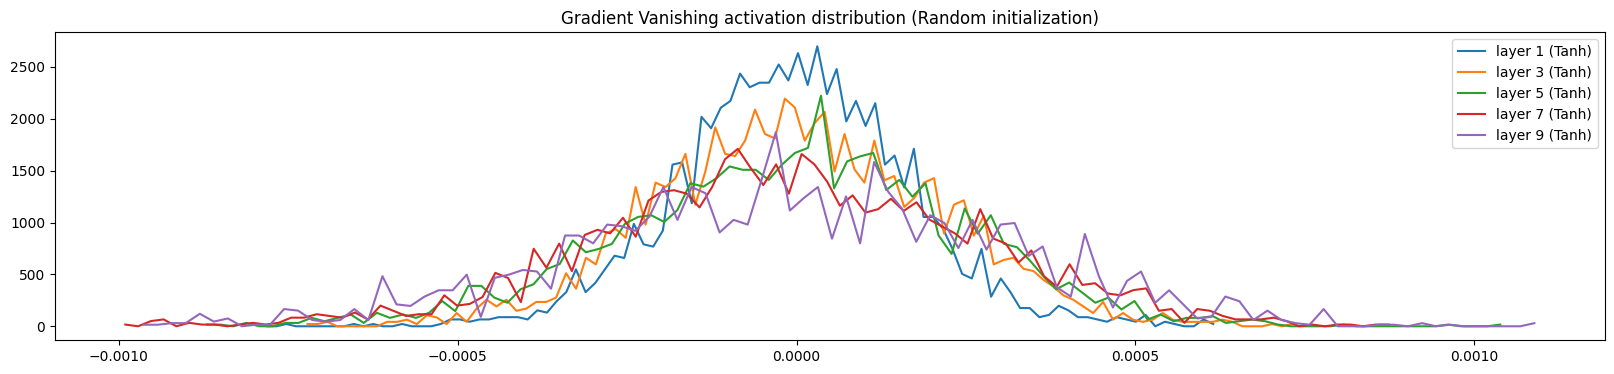

In [ ]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out.grad
        t = t.cpu().detach()
        print(" layer %d (%10s):     mean %+.2f,     std %.2f,   var %.2f,   saturated %.2f%%" % (i,layer.__class__.__name__,t.mean().item(),t.std().item(),t.var().item(),((t.abs())>0.97).float().mean().item() * 100))
        hy,hx = torch.histogram(t,density=True)     # hist, bin_edges 
        plt.plot(hx[:-1].detach(),hy.detach())      
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Gradient Vanishing activation distribution (Random initialization)");

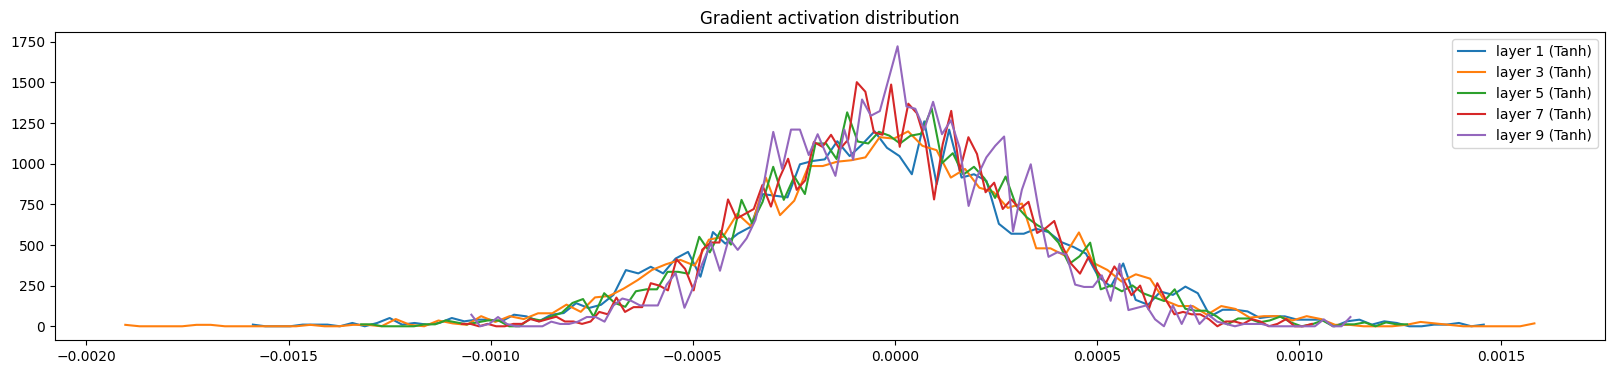

In [ ]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out.grad
        t = t.cpu().detach()
        print(" layer %d (%10s):     mean %+.2f,     std %.2f,   var %.2f,   saturated %.2f%%" % (i,layer.__class__.__name__,t.mean().item(),t.std().item(),t.var().item(),((t.abs())>0.97).float().mean().item() * 100))
        hy,hx = torch.histogram(t,density=True)     # hist, bin_edges  
        plt.plot(hx[:-1].detach(),hy.detach())      
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Gradient activation distribution");

- Comparing Figures 1 and 2, we observe a significant drop in the gradient magnitude in Figure 1, but not in Figure 2. 
- This can be attributed to the more effective parameter initialization in Figure 2, which helps mitigate the saturation effect of the tanh activation function.
- As a result, the gradient flow through the network is improved, preventing the vanishing gradient and explosion problem and enabling more efficient learning

### Figure1 : 
- we can observe that,gradient is getting lower and lower layer by layer, so when we move deeper the gradient would closer to zero and the Model cannot learn nothing. 

### Figure 2: 
- No sign of gradient vanishing or explosion. 

## Without Tanh(x)

In [40]:
layers = [
    Linear(fan_in=n_emb * block_size,fan_out=n_hidden),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),
    Linear(fan_in=        n_hidden,  fan_out=vocab_size)
]


with torch.no_grad():
    layers[-1].weight *= 0.1           # for fixing initial loss
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3         # he initialization 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total numbers of parameters in this model : {sum(p.nelement() for p in parameters)}")
for para in parameters:
    para.requires_grad = True

Total numbers of parameters in this model : 46497


In [41]:
n_iter      = 200000
batch_size  = 32
loss_i      = []

for i in range(1):

    # mini batch
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 
    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    x           = emb.view(emb.shape[0],-1) # (32,30)
    for layer in layers:
        x = layer(x)                        # output ==>> (32 * 27) ==>> (batch_size * vocab_size)
    loss = F.cross_entropy(x,y_batch)       # expect initial loss   ==>> (1/27) = 
    #backward pass 
    for layer in layers:
        layer.out.retain_grad()
        
    for para in parameters:
        para.grad = None
    loss.backward()
    # update the parameters
    lr = 0.1 if n_iter < 100000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += - lr * para.grad

    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())
    

      0/ 200000 :   4.4593


 layer 0 (    Linear):     mean -0.059980,     std 1.701948e+00,   var 2.90,   saturated 56.88%
 layer 1 (    Linear):     mean -0.156945,     std 2.864486e+00,   var 8.21,   saturated 72.12%
 layer 2 (    Linear):     mean +0.045795,     std 4.802721e+00,   var 23.07,   saturated 82.53%
 layer 3 (    Linear):     mean +0.246533,     std 7.335728e+00,   var 53.81,   saturated 89.25%
 layer 4 (    Linear):     mean -0.325153,     std 1.253653e+01,   var 157.16,   saturated 94.22%


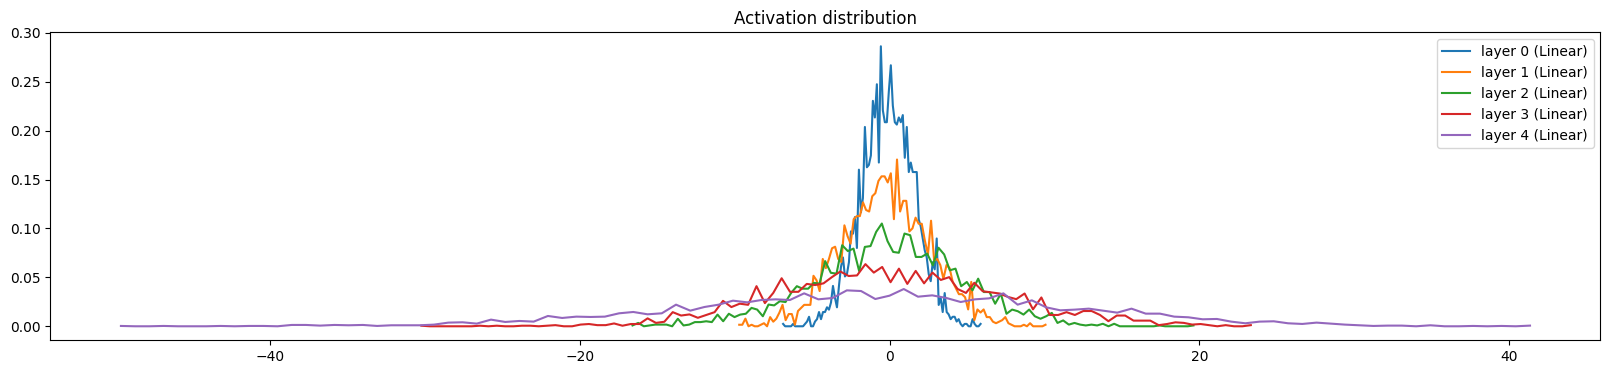

In [42]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Linear):
        t = layer.out
        t = t.cpu().detach()
        print(" layer %d (%10s):     mean %+f,     std %e,   var %.2f,   saturated %.2f%%" % (i,layer.__class__.__name__,t.mean().item(),t.std().item(),t.var().item(),((t.abs())>0.97).float().mean().item() * 100))
        hy,hx = torch.histogram(t,density=True)     # hist, bin_edges 
        plt.plot(hx[:-1].detach(),hy.detach())      
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Activation distribution");

 layer 0 (    Linear):     mean +0.000056,     std 2.347160e-03,     
 layer 1 (    Linear):     mean +0.000023,     std 1.413539e-03,     
 layer 2 (    Linear):     mean -0.000030,     std 8.984328e-04,     
 layer 3 (    Linear):     mean +0.000016,     std 5.485353e-04,     
 layer 4 (    Linear):     mean +0.000001,     std 3.258782e-04,     


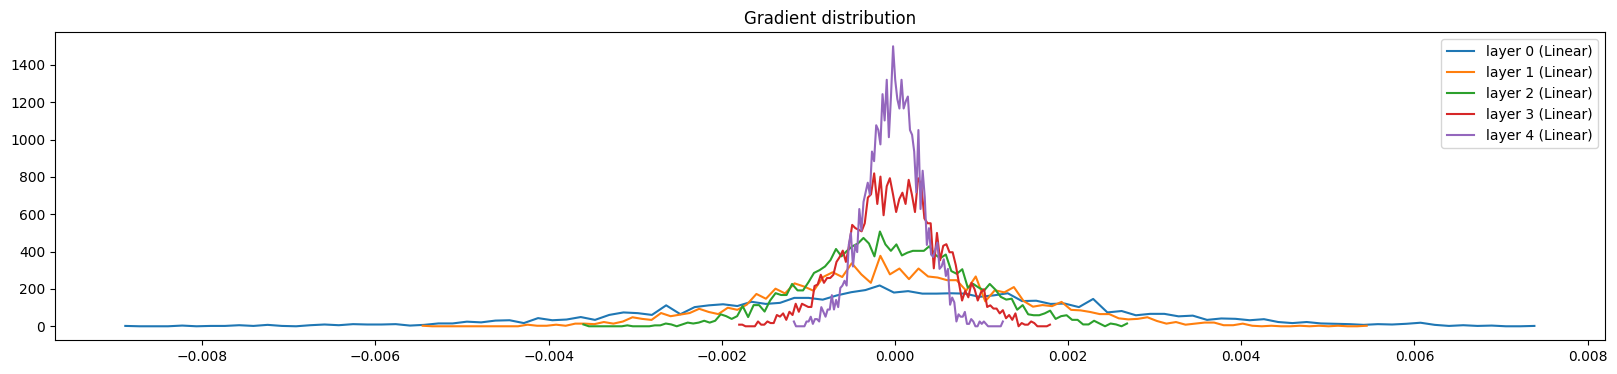

In [43]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Linear):
        t = layer.out.grad
        t = t.cpu().detach()
        print(" layer %d (%10s):     mean %+f,     std %e,     " % (i,layer.__class__.__name__,t.mean().item(),t.std().item()))
        hy,hx = torch.histogram(t,density=True)     # hist, bin_edges 
        plt.plot(hx[:-1].detach(),hy.detach())      
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Gradient distribution");

- Stack the all the liear layers and get a nice output (activation), but its just a massive linear layer and turns out into a sinele linear layer in terms of its representation power. 
- Non linear layers are helps linear layer models in any kind of arbitory functions. 



## Model 

In [69]:
layers = [
    Linear(fan_in=n_emb * block_size,fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=vocab_size)
]


with torch.no_grad():
    layers[-1].weight *= 0.1           # for fixing initial loss
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3         # he initialization 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total numbers of parameters in this model : {sum(p.nelement() for p in parameters)}")
for para in parameters:
    para.requires_grad = True

Total numbers of parameters in this model : 46497


In [70]:
n_iter      = 200000
batch_size  = 32
loss_i      = []
update      = []        # update the ratio between grad and data ==>> lr * para.grad.std() / para.data.std()

for i in range(200000):

    # mini batch
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 
    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    x           = emb.view(emb.shape[0],-1) # (32,30)
    for layer in layers:
        x = layer(x)                        # output ==>> (32 * 27) ==>> (batch_size * vocab_size)
    loss = F.cross_entropy(x,y_batch)       # expect initial loss   ==>> (1/27) = 
    #backward pass 
    for layer in layers:
        layer.out.retain_grad()
        
    for para in parameters:
        para.grad = None
    loss.backward()
    # update the parameters
    lr = 0.1 if n_iter < 155000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += - lr * para.grad

    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    with torch.no_grad():
        update.append([((lr*para.grad).std() / para.data.std()).log10().item() for para in parameters])



      0/ 200000 :   3.3033
  10000/ 200000 :   2.1553
  20000/ 200000 :   2.0667
  30000/ 200000 :   1.9310
  40000/ 200000 :   2.1133
  50000/ 200000 :   2.1920
  60000/ 200000 :   2.0601
  70000/ 200000 :   2.0586
  80000/ 200000 :   2.0978
  90000/ 200000 :   2.2484
 100000/ 200000 :   2.1238
 110000/ 200000 :   2.5129
 120000/ 200000 :   2.3927
 130000/ 200000 :   2.1997
 140000/ 200000 :   2.3710
 150000/ 200000 :   2.2781
 160000/ 200000 :   2.1498
 170000/ 200000 :   2.0460
 180000/ 200000 :   2.0734
 190000/ 200000 :   2.2854


weight 0   (27, 10)  |   mean +0.000451    |  std 2.720011e-02  | grad:data ratio 2.518908e-02
weight 1  (30, 100)  |   mean +0.000034    |  std 2.338269e-02  | grad:data ratio 6.946299e-02
weight 3 (100, 100)  |   mean -0.000037    |  std 1.742314e-02  | grad:data ratio 9.073862e-02
weight 5 (100, 100)  |   mean -0.000136    |  std 1.495340e-02  | grad:data ratio 7.715952e-02
weight 7 (100, 100)  |   mean -0.000091    |  std 1.354689e-02  | grad:data ratio 7.064669e-02
weight 9 (100, 100)  |   mean +0.000096    |  std 1.149332e-02  | grad:data ratio 6.007829e-02
weight 11  (100, 27)  |   mean +0.000000    |  std 2.246249e-02  | grad:data ratio 1.252302e-01


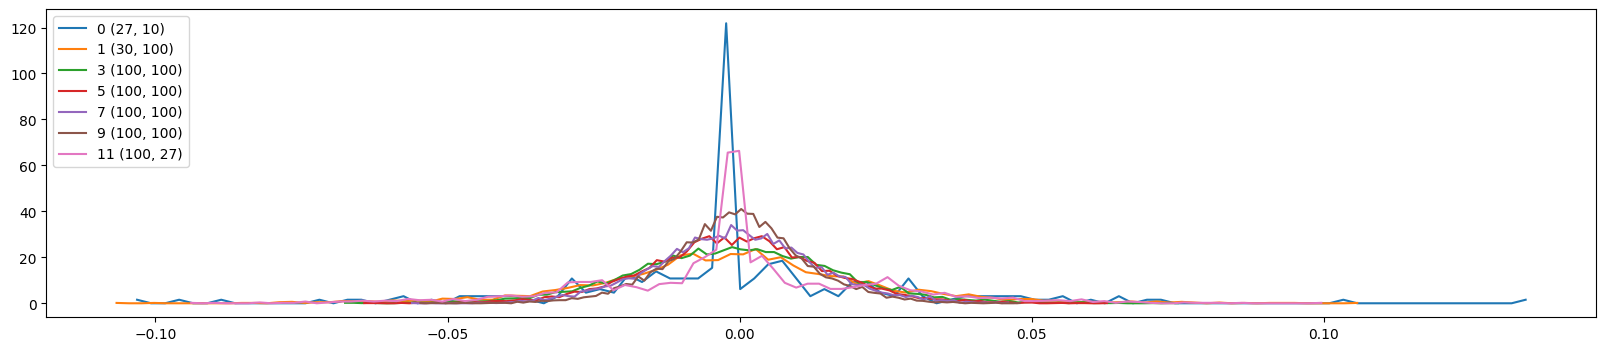

In [71]:
plt.figure(figsize=(20,4))
legends =  []
for i, para in enumerate(parameters):
    t = para.grad
    if para.ndim == 2:
        print('weight %d %10s  |   mean %+f    |  std %e  | grad:data ratio %e' % (i,tuple(para.shape),t.mean(),t.std(),t.std() / para.std()))
        hy,hx = torch.histogram(t.cpu().detach(),density=True)
        plt.plot(hx[:-1],hy.cpu().detach())
        legends.append(f"{i} {tuple(para.shape)}")
plt.legend(legends,loc="upper left");

#### (Here the iteration = 1)
- Look at the gradient and data ratio (gradient / data), 
- By ploting the gradient to data ratio, It gives us the idea of what is the `scale of gradient compared to scale of actual values`.
    - By updating the data, we multiply the data with learning rate (step update). `para.data += -learning_rate * para.grad`
    -  So that, gradient has larger magnitude. 
        - If numbers in gradient has larger compaired to numbers in data == Got bad effect.<br><br>


 - weight_0   (27, 10)  |   mean -0.000047    |  std 0.001489  | grad:data ratio 1.499960e-03
    - Most of the Value in `gradient` is 1000 times smaller than value in `data`.   





## Update Ratio over time

- Actually `grad:data` ratio is not much informative, But update to data ratio is much informative. 
- `Update to data ratio`: Amount by which we will actually change the data. 
    - How much we update grad to data


- This ratio is telling us, `How great are the update to the value to the tensors`

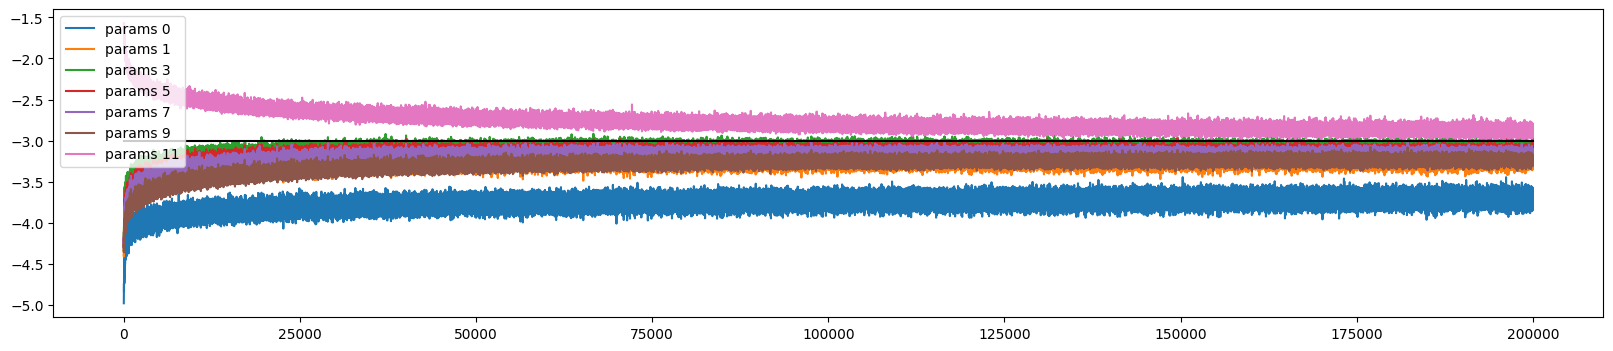

In [72]:
plt.figure(figsize=(20,4))
legends =  []
for i, para in enumerate(parameters):
    if para.ndim == 2:
        plt.plot([update[j][i] for j in range(len(update))])
        
        legends.append("params %d" % i)
plt.plot([0, len(update)],[-3,-3],"k")                          # these ratio should be ~1e-3, indicate on plot  
plt.legend(legends,);

- Params_11 is learned so fast, it represented in this graph, There is a black line representing perticular learnig rate, if the params below this line means , the parameters are learned so weakly, 



## Batch normalization

In [102]:
layers = [
    Linear(fan_in=n_emb * block_size,fan_out=n_hidden),BatchNormalization(n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),BatchNormalization(n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),BatchNormalization(n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),BatchNormalization(n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=n_hidden),BatchNormalization(n_hidden),Tanh(),
    Linear(fan_in=        n_hidden,  fan_out=vocab_size),BatchNormalization(vocab_size),
]


with torch.no_grad():
    layers[-1].gamma *= 0.1           # for fixing initial loss, (inorder to make softmax less confident)
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3         # he initialization 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total numbers of parameters in this model : {sum(p.nelement() for p in parameters)}")
for para in parameters:
    para.requires_grad = True

Total numbers of parameters in this model : 47551


in batchnormalization, output is looks like

```self.out = self.gamma * x_hat + self.beta```

so we don't need to set the last layer weight. In this case we would changing gamma parameter for making softmax less confident. 



In [103]:
n_iter      = 200000
batch_size  = 32
loss_i      = []
update      = []        # update the ratio between grad and data ==>> lr * para.grad.std() / para.data.std()

for i in range(n_iter):

    # mini batch
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 
    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    x           = emb.view(emb.shape[0],-1) # (32,30)
    for layer in layers:
        x = layer(x)                        # output ==>> (32 * 27) ==>> (batch_size * vocab_size)
    loss = F.cross_entropy(x,y_batch)       # expect initial loss   ==>> (1/27) = 
    #backward pass 
    for layer in layers:
        layer.out.retain_grad()
        
    for para in parameters:
        para.grad = None
    loss.backward()
    # update the parameters
    lr = 0.1 if n_iter < 155000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += - lr * para.grad

    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    with torch.no_grad():
        update.append([((lr*para.grad).std() / para.data.std()).log10().item() for para in parameters])

 

      0/ 200000 :   3.2965
  10000/ 200000 :   2.2959
  20000/ 200000 :   2.1446
  30000/ 200000 :   2.2686
  40000/ 200000 :   2.2711
  50000/ 200000 :   2.0580
  60000/ 200000 :   2.2097
  70000/ 200000 :   2.3413
  80000/ 200000 :   2.0952
  90000/ 200000 :   1.7497
 100000/ 200000 :   2.1010
 110000/ 200000 :   2.4710
 120000/ 200000 :   2.1659
 130000/ 200000 :   2.1709
 140000/ 200000 :   2.3010
 150000/ 200000 :   2.4200
 160000/ 200000 :   2.1230
 170000/ 200000 :   2.1483
 180000/ 200000 :   2.3166
 190000/ 200000 :   2.2024


## Activation 

 layer 2 (      Tanh):     mean -0.004168,     std 0.6338,   var 0.40,   saturated 4.56%
 layer 5 (      Tanh):     mean -0.000293,     std 0.6524,   var 0.43,   saturated 5.22%
 layer 8 (      Tanh):     mean +0.006441,     std 0.6645,   var 0.44,   saturated 4.84%
 layer 11 (      Tanh):     mean -0.004579,     std 0.6788,   var 0.46,   saturated 4.66%
 layer 14 (      Tanh):     mean -0.002052,     std 0.6908,   var 0.48,   saturated 3.84%


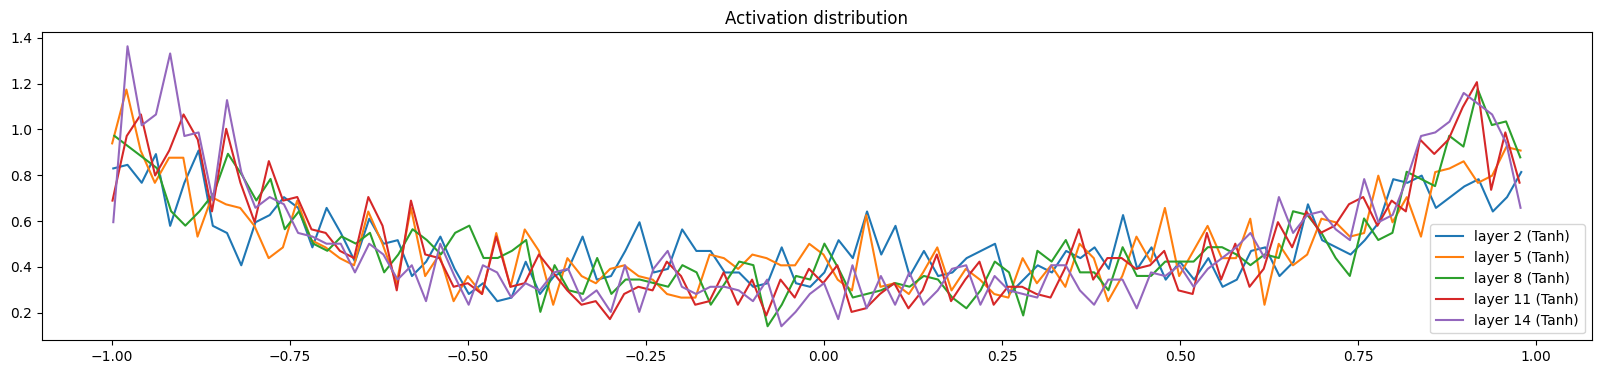

In [110]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out
        t = t.cpu().detach()
        print(" layer %d (%10s):     mean %+f,     std %.4f,   var %.2f,   saturated %.2f%%" % (i,layer.__class__.__name__,t.mean().item(),t.std().item(),t.var().item(),((t.abs())>0.97).float().mean().item() * 100))
        hy,hx = torch.histogram(t,density=True)     # hist, bin_edges 
        plt.plot(hx[:-1].detach(),hy.detach())      
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Activation distribution");

- Every single tanh() layers looks good. 
- Std is roughly same for entire layers (homogeneous). 

## Gradient

 layer 2 (      Tanh):     mean +0.000000,     std 5.984987e-03,     
 layer 5 (      Tanh):     mean -0.000000,     std 5.410083e-03,     
 layer 8 (      Tanh):     mean -0.000000,     std 5.246297e-03,     
 layer 11 (      Tanh):     mean +0.000000,     std 5.422030e-03,     
 layer 14 (      Tanh):     mean +0.000000,     std 5.099178e-03,     


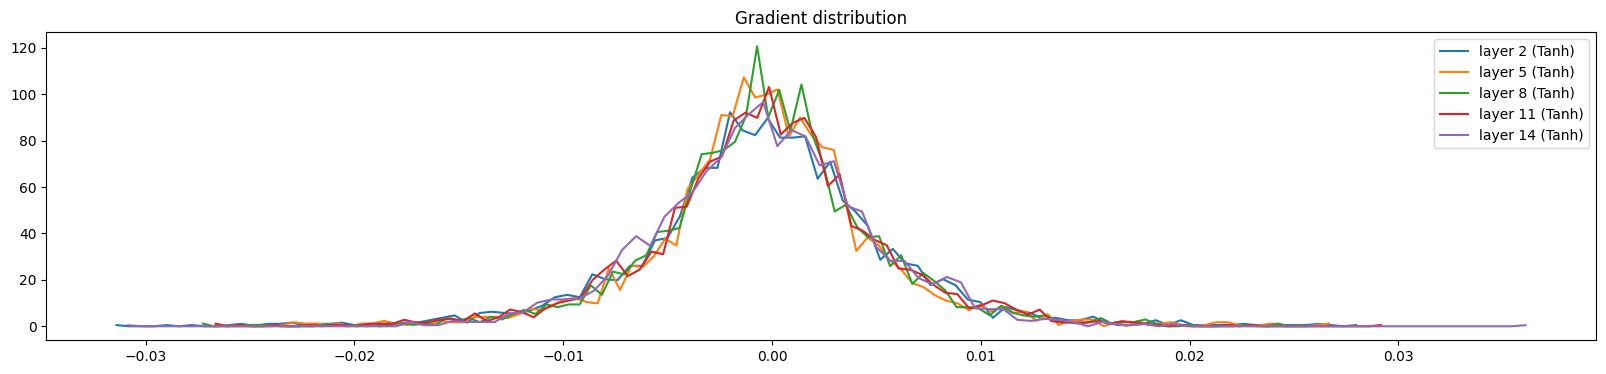

In [109]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out.grad
        t = t.cpu().detach()
        print(" layer %d (%10s):     mean %+f,     std %e,     " % (i,layer.__class__.__name__,t.mean().item(),t.std().item()))
        hy,hx = torch.histogram(t,density=True)     # hist, bin_edges 
        plt.plot(hx[:-1].detach(),hy.detach())      
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Gradient distribution");

## Weight

weight 0   (27, 10)  |   mean -0.000000    |  std 1.537769e-02  | grad:data ratio 1.421659e-02
weight 1  (30, 100)  |   mean -0.000003    |  std 1.540844e-02  | grad:data ratio 4.996644e-02
weight 5 (100, 100)  |   mean -0.000027    |  std 1.249165e-02  | grad:data ratio 7.112288e-02
weight 9 (100, 100)  |   mean -0.000017    |  std 1.203944e-02  | grad:data ratio 6.896501e-02
weight 13 (100, 100)  |   mean +0.000237    |  std 1.220200e-02  | grad:data ratio 7.035096e-02
weight 17 (100, 100)  |   mean +0.000068    |  std 1.135557e-02  | grad:data ratio 6.541321e-02
weight 21  (100, 27)  |   mean -0.000054    |  std 1.949451e-02  | grad:data ratio 1.032420e-01


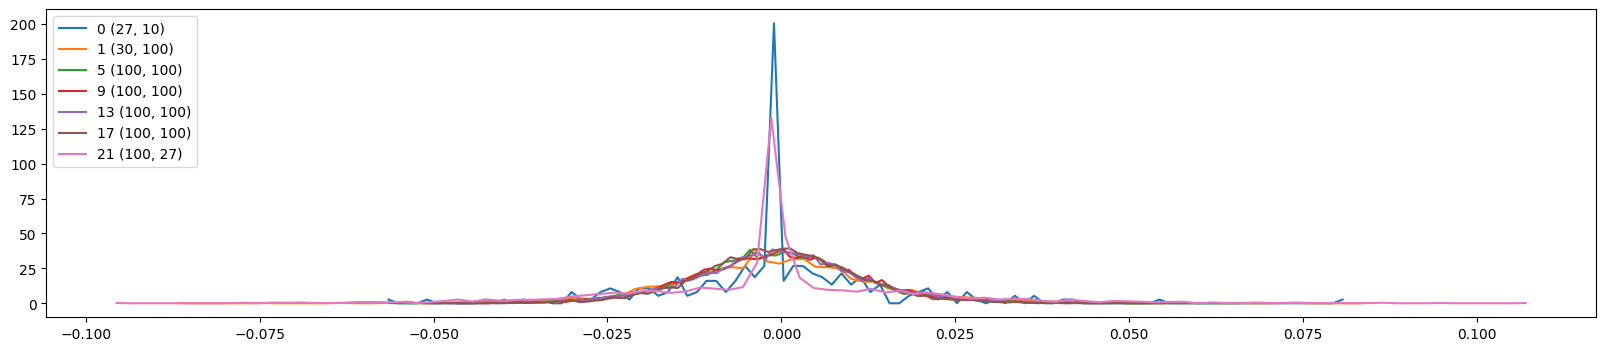

In [111]:
plt.figure(figsize=(20,4))
legends =  []
for i, para in enumerate(parameters):
    t = para.grad
    if para.ndim == 2:
        print('weight %d %10s  |   mean %+f    |  std %e  | grad:data ratio %e' % (i,tuple(para.shape),t.mean(),t.std(),t.std() / para.std()))
        hy,hx = torch.histogram(t.cpu().detach(),density=True)
        plt.plot(hx[:-1],hy.cpu().detach())
        legends.append(f"{i} {tuple(para.shape)}")
plt.legend(legends,loc="upper left");

## Udpate : data ratio

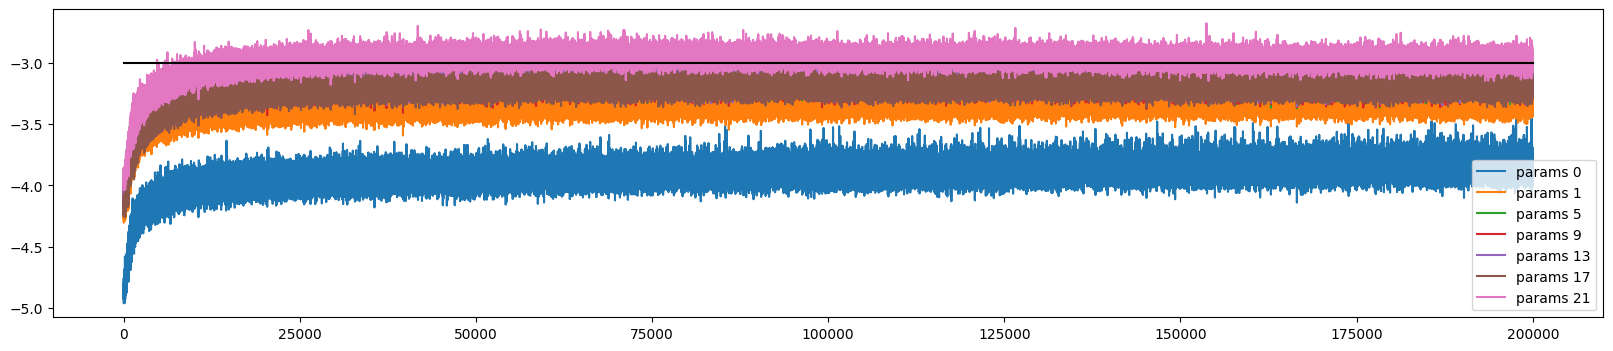

In [112]:
plt.figure(figsize=(20,4))
legends =  []
for i, para in enumerate(parameters):
    if para.ndim == 2:
        plt.plot([update[j][i] for j in range(len(update))])
        
        legends.append("params %d" % i)
plt.plot([0, len(update)],[-3,-3],"k")                          # these ratio should be ~1e-3, indicate on plot  
plt.legend(legends,);

update the learning rate, if the update : data ratio is lesser than the black line. 